In [1]:
# Base
import time
import datetime

# Data Manipulation
import pandas as pd
import polars as pl

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
#from adjustText import adjust_text

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Scripts
from Scripts.fetch_utils import fetch_league
from Scripts.analytic_utils import *
from Scripts.scrape_player_stats import *
from Scripts.scrape_team_stats import *
from Scripts.luck_index import *
from Scripts.tidbit_utils import *
from Scripts.simulation_utils import *
#from Scripts.lineup_projections import *

#Fantasy_Pros_Projection_Data = 

# Constants
espn_id = 'AEB61FldCpFLVPDUlhuAq0HiJPhiRqGeqVZoSv1gqxveRGB%2BLzGTtEXE3FIvrPK3qoGrOjXE%2FoKqJADgjzYTsJva22%2BtxhsiEQOiLaBNuh%2FoLLfyY4pewmwNQvDnQ6paTcGaOfktKbZidsvEUc061%2FFYnMxMJ596%2F9HrQQCsbH575%2Bp6bi1Vy80GEVtgjfmp03dSSdjsYoxDMVn403%2BI8rB1HkfFAGcnbbXJq9wVjN6E1xglOkDprydZk5HrX%2FOr7QFt1DBNZHVdv52RO6jEEDTUBGNCYgQgzzTTsl%2FaVw8CgNfilAnku6DzS%2BZFoGhhtw8%3D'
s_id = '{796FF49A-04B4-481F-9132-1F91C9585A05}'

lg_vars = {
    "Winfield_Football": {
        "ID": 521152,
        "ESPN_S2": "AECd6kezzt5c3URGK%2FEHxqSyREcJWZX7JUHahtPHI8SV8KK13PkZG98FJYsIQ%2FFTiA5YXhcfcaQ7bGRGZZzzgz7BQSci5bFMfx1xPTCM95tyCvx%2BBJgIACFkxz%2B5J3uz0Ez87c1XWV%2FuQB%2FjgXXBRvAZaMIBaSnfJ842nwUpjS4x6U6r6FNi900ORFBxtdKU%2FQ6Bvr6UVZKerid0TdatKkFq0IrRYlFr3npOSWsv5bzIV9uh8HidTJlYx%2Bf3DYqZABpGEZfLeuJyymEQ%2BJjXGbaOAjZhOP%2FRrrqpS0xvYbFiwET2MCEmraBsiJcqWR6VaIM%3D",
        "SWID": "{DC47642F-1CD6-4451-9C5B-08FFE2844F9E}",
        "start": 2016,
        "end": 2025
    },
    "Weenieless_Wanderers": {
        "ID": 537814,
        "ESPN_S2": espn_id,
        "SWID": s_id,
        "start": 2015,
        "end": 2025
    },
    "GOP_Degenerates": {
        "ID": 1727104,
        "ESPN_S2": espn_id,
        "SWID": s_id,
        "start": 2023,
        "end": 2025
    },
    "Knights_FFL": {
        "ID": 1992637246,
        "ESPN_S2": espn_id,
        "SWID": s_id,
        "start": 2022,
        "end": 2025
    },
    "12 Dudes one Cup": {
        "ID": 1895076862,
        "ESPN_S2": "AECd6kezzt5c3URGK%2FEHxqSyREcJWZX7JUHahtPHI8SV8KK13PkZG98FJYsIQ%2FFTiA5YXhcfcaQ7bGRGZZzzgz7BQSci5bFMfx1xPTCM95tyCvx%2BBJgIACFkxz%2B5J3uz0Ez87c1XWV%2FuQB%2FjgXXBRvAZaMIBaSnfJ842nwUpjS4x6U6r6FNi900ORFBxtdKU%2FQ6Bvr6UVZKerid0TdatKkFq0IrRYlFr3npOSWsv5bzIV9uh8HidTJlYx%2Bf3DYqZABpGEZfLeuJyymEQ%2BJjXGbaOAjZhOP%2FRrrqpS0xvYbFiwET2MCEmraBsiJcqWR6VaIM%3D",
        "SWID": "{DC47642F-1CD6-4451-9C5B-08FFE2844F9E}",
        "start": 2024,
        "end": 2025
    },
    "Big Red Fantasy Football": {
        "ID": 820145,
        "ESPN_S2": "AEBEMc4%2BdfLmeqLeujWJ5vXngkv7UEIRNlCK8we%2BOe%2FPqBZbSlGGHINN%2BFue6%2F1%2BAYun1N%2FFqJTDmim%2FY1N1yZj4PatflCQdsSqvnLUx7l%2FdabKDBTJArnWT8PA9IhKdJAAsZgwC%2FlOKx8mJ7gMp11ppccZF6ycJ8%2FSIeKe65LimLfUERkw7cmRhIaXuFlqTb8qQMcMq9L3cjJv7vnBXa%2F2WD3liCL0Wn6ZmzsCRcTb8VALiRUeIHbgBFL4LET7xFUgxFHNYXmzPUObhwTcKGFQ%2FTGVDNUjHXpR%2BC%2BU2rVnm%2Fw%3D%3D",
        "SWID": "{69874D0A-9596-44FA-A011-A1F2C03C5815}"
    }
}

## 1) Set League ##

In [2]:
select_league = "GOP_Degenerates" # Winfield_Football, Knights_FFL, GOP_Degenerates, Weenieless_Wanderers

league = fetch_league(
        league_id=lg_vars[select_league]['ID'],
        year=lg_vars[select_league]['end'],
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2']
    )

BUILDING 2025 Season For GOP Degenerates 


### Current Analysis

#### Current Lineup

In [3]:
lineups = get_ply_stats_by_matchup(league_id=lg_vars[select_league]['ID'],
                year=2025,
                swid=lg_vars[select_league]['SWID'],
                espn_s2=lg_vars[select_league]['ESPN_S2'])

free_agents = build_fa_market(league=league)

lineups = pd.concat([lineups, free_agents])

lineups.fillna(0, inplace=True)

lineups = lineups.drop_duplicates(subset=['week', 'player_name'])

BUILDING 2025 Season For GOP Degenerates 


In [32]:
def change_col_prefix(df, old_pfix, new_pfix):

    df = df
    df.columns = df.columns.str.replace(f'{old_pfix}', new_pfix, regex=False)
    return df

def impute_columns(df, target_prefix, source_prefix):
    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    source_cols = [col for col in df.columns if col.startswith(source_prefix)]

    for source_col in source_cols:
        # Define the corresponding target column name
        target_col = target_prefix + source_col[len(source_prefix):]
        
        # If the target column does not exist, create it by copying the values from the source column
        if target_col not in df.columns:
            df[target_col] = df[source_col]
        
        # If the target column exists, impute missing values from the source column
        elif source_col in df.columns:
            df[target_col] = df[target_col].fillna(df[source_col])
    
    return df

def create_mean_cols(df, target_prefix, source_prefix, mean_prefix='MEAN_'):
    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    source_cols = [col for col in df.columns if col.startswith(source_prefix)]

    for source_col in source_cols:
        target_col = target_prefix + source_col[len(source_prefix):]
        mean_col = mean_prefix + source_col[len(source_prefix):]

        if target_col in df.columns and source_col in df.columns:
            df[mean_col] = df[[target_col, source_col]].mean(axis=1)

    df = df[['week', 'player_name', 'primaryPosition','player_active_status']  + list(df.filter(like='MEAN_').columns)]

    return df

def clean_pinny(pinny_path="Data/Projections/Pinnacle/Props/Pinnacle_Props_Week_All.parquet"):

    # Constants
    prop_to_stat={
        "Touchdowns": 'rushingTouchdowns',
        "Rushing Yards": "rushingYards",
        "Rush Attempts": 'rushingAttempts',

        "Receiving Yards": "receivingYards",
        "Receptions": "receivingReceptions",

        "Touchdown Passes": "passingTouchdowns",
        "Pass Completions": "passingCompletions",
        "Pass Attempts": "passingAttempts",
        "Passing Yards": "passingYards",
        "Interceptions": "passingInterceptions"
    }

    name_changes={
        # Pinny -> ESPN #
        "Tre Harris": "Tre' Harris",
    #    "Bhayshul Tuten"
        "Marvin Mims": "Marvin Mims Jr.",
    #    "Nick Westbrook-Ikhine"
        "Travis Etienne": "Travis Etienne Jr.",
    #    "Jauan Jennings"
    #    "Darren Waller"
    #    "Romeo Doubs"
    #    "Dylan Sampson"
    #    "Jayden Higgins"
    #    "Woody Marks"
    #    "Jayden Reed"
        "Aaron Jones": "Aaron Jones Sr.",
        "Kyle Pitts": "Kyle Pitts Sr.",
    #    "Cam Skattebo"
    #    "Khalil Shakir"
    #    "Keon Coleman"
        "Calvin Austin": "Calvin Austin III",
    #    "Ricky Pearsall"
        "Ollie Gordon":"Ollie Gordon II"
    #    "Ja'Tavion Sanders"
    #    "Josh Downs"
    #    "Tyler Warren"
    #    "Joshua Palmer"
    }

    # Load
    raw=pd.read_parquet(pinny_path)

    # Get Stats
    raw.replace({"PropType": prop_to_stat}, inplace=True)

    # Filter
    raw = raw[raw['PropType'].isin(list(prop_to_stat.values()))]

    # Clean Names
    raw.replace({"Player": name_changes}, inplace=True)

    # Replace NaN in Value with ImpNoVig
    raw['Value'] = raw['Value'].fillna(raw['ImpNoVig'])

    def adjust_value(df):
        pivoted_df = df.pivot_table(
            index=['officialDate', 'week', 'Away', 'Home', 'Player', 'PropType', 'Value', 'BetTimeStamp'],
            columns='OverUnder',
            values=['Price', 'Implied', 'ImpNoVig'],
            aggfunc='first'  # Use 'first' in case there are duplicates
        ).reset_index()

        # Flatten the column names and add OverUnder values as suffixes
        pivoted_df.columns.name = None
        new_columns = []

        for col in pivoted_df.columns:
            if col[0] in ['Price', 'Implied', 'ImpNoVig']:
                new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append(col[0])

        pivoted_df.columns = new_columns

        # Create Adjusted Values From Juice
        pivoted_df["Juice"] = pivoted_df['Implied_Over'] + pivoted_df['Implied_Under']
        pivoted_df["Over_Juice"] = (1 / pivoted_df['Implied_Over'] - 1)
        pivoted_df["Under_Juice"] = (1 / pivoted_df['Implied_Under'] - 1)
        pivoted_df["Juice_Diff"] = pivoted_df["Under_Juice"] - pivoted_df["Over_Juice"]
        pivoted_df["AdjValue"] = pivoted_df["Value"] + (pivoted_df["Juice_Diff"] * pivoted_df["Value"] * 0.5)

        return pivoted_df
    
    adjusted = adjust_value(raw)


    adjusted = adjusted[['week', 'Player', 'PropType', 'AdjValue']]
    adjusted.columns = ['week', 'player_name', 'statType', 'statValue']

    # Pivot
    clean = adjusted.pivot_table(index=['week','player_name'], columns='statType', values='statValue', aggfunc='mean').reset_index()

    

    # Split Touchdowns by Usage (Rushing/Receiving)
    if 'rushingTouchdowns' in clean.columns:
        clean['receivingTouchdowns'] = clean['rushingTouchdowns'] * (clean['receivingYards'] / (clean['receivingYards'] + clean['rushingYards']))
        clean['rushingTouchdowns'] = clean['rushingTouchdowns'] - clean['receivingTouchdowns']

    clean.columns = ['week', 'player_name'] + ['proj_' + str(col) for col in clean.columns[2:]]
    clean = clean[['week', 'player_name'] + list(clean.columns[2:])]

    # Flatten If Needed
    clean.columns.name = None
    clean.columns = [col if col is not None else 'StatValue' for col in clean.columns]

    #final = proj_to_score(proj_df=clean, col_pfix="PINNY")

    return clean

def clean_bol(bol_path = "Data/Projections/BetOnline/Season/BetOnline_AllProps.parquet"):

    raw = pd.read_parquet(bol_path).drop(columns=['position', 'team'])

    name_changes={
        # BOL -> ESPN #
        "Tre Harris": "Tre' Harris",
        "Kyle Pitts": "Kyle Pitts Sr.",
        "Deebo Samuel Sr.":"Deebo Samuel",
        "Cameron Ward":"Cam Ward",
        "Marquise Brown":"Hollywood Brown",
    }

    if 'proj_defensiveTotalTackles' in raw.columns:
        raw['proj_defensiveSoloTackles'] = raw['proj_defensiveTotalTackles'] * 0.75
        raw['proj_defensiveAssistedTackles'] = raw['proj_defensiveTotalTackles'] * 0.5

    raw.replace({"player_name": name_changes}, inplace=True)

    return raw

def get_match_details(df1, df2, keys, check_col2, min_wk, tbl_lab):

    # Only Check Weeks that Exist in Data w/ Projected Stats
    df1 = df1[(df1['week'] == min_wk) & (~df1['primaryPosition'].isin(['D/ST', 'K', 'DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB']))]
    df1 = df1[df1.filter(like='MEAN_').sum(axis=1) > 0]
    df1 = df1[df1['player_active_status'] == 'active']

    # Option 1 - Count unmatched values
    merged_df = pd.merge(df1, df2, on=keys, how='left')
    unmatched_from_df2 = merged_df[check_col2].isnull().sum()
    
    # If > 0, print more information
    if unmatched_from_df2 > 0:
        print(f'Unmatched from {tbl_lab}: {unmatched_from_df2}')

        merged_df = pd.merge(df1, df2, on=keys, how='left', indicator=True)
        unmatched_rows = merged_df[merged_df['_merge'] != 'both']
        unmatched_count = unmatched_rows.shape[0]
        print(unmatched_rows[['week', 'player_name']])

        # Option 3 - Grouping To get Count
        unmatched_count = merged_df['_merge'].value_counts()
        print(unmatched_count)
        print(" ")
    elif unmatched_from_df2 == 0:
        print(f"All Rows in {tbl_lab} Match")
        print(" ")

def compute_weighted_stats(df, stats_list, weights_dict):
    """
    Compute weighted stats for the given statistics in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the stats.
    - stats_list (list): A list of stat prefixes to compute.
    - weights_dict (dict): A nested dictionary where keys are stat prefixes and values are dictionaries
                           of sources and their corresponding weights.

    Returns:
    - pd.DataFrame: The updated DataFrame with the new weighted stat columns.
    """
    for stat in stats_list:
        new_column_name = f'TRUE_{stat}'
        df[new_column_name] = 0  # Initialize the new column

        # Check if the stat has specific weights defined
        if stat in weights_dict:
            for source, weight in weights_dict[stat].items():
                # Construct the column name based on the source and stat
                col_name = f"{source}_{stat}"
                if col_name in df.columns:
                    # Add the weighted contribution to the new column
                    df[new_column_name] += df[col_name] * weight
        else:
            # If no specific weights are defined for the stat, use default weights
            for source, weight in weights_dict['default'].items():
                col_name = f"{source}_{stat}"
                if col_name in df.columns:
                    df[new_column_name] += df[col_name] * weight
    
    return df

scores_df = build_scoring_table(league=league)

def proj_to_score(proj_df, col_pfix_list=['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE'], s_df=scores_df):

    # Update scores in s_df for D/ST positions and specific conditions
    if 1727104 in list(proj_df['league_id'].unique()):
        dp_df = proj_df[proj_df['primaryPosition'].isin(['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB'])]
        normal_df = proj_df[~proj_df['primaryPosition'].isin(['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB'])]

        s_df.loc[s_df['id'] == 99, 'points'] = 1
        s_df.loc[s_df['id'] == 109, 'points'] = 0
        s_df.loc[s_df['id'] == 112, 'points'] = 0
        s_df.loc[s_df['id'] == 113, 'points'] = 0
        s_df.loc[s_df['id'] == 95, 'points'] = 1
        s_df.loc[s_df['id'] == 97, 'points'] = 1

        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            normal_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in normal_df.columns:
                    normal_df[f'{col_pfix}_Points'] += normal_df[col_name] * score_row['points']


        # Handle DP 
        s_df.loc[s_df['id'] == 95, 'points'] = 12
        s_df.loc[s_df['id'] == 97, 'points'] = 2
        s_df.loc[s_df['id'] == 99, 'points'] = 10
        s_df.loc[s_df['id'] == 112, 'points'] = 5
        s_df.loc[s_df['id'] == 113, 'points'] = 5
        s_df.loc[s_df['id'] == 109, 'points'] = 1

        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            dp_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in dp_df.columns:
                    dp_df[f'{col_pfix}_Points'] += dp_df[col_name] * score_row['points']

        proj_df = pd.concat([normal_df, dp_df])

    else:
        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            proj_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in proj_df.columns:
                    proj_df[f'{col_pfix}_Points'] += proj_df[col_name] * score_row['points']
    
    return proj_df

def clean_lineups(df=lineups):

    # Get Base of Projections (player_name, week, team, etc.)
    base_cols = ['league_id','year','week', 'team_owner', 'team_name', 'team_division', 'player_name', 'player_id', 'slotPosition', 'primaryPosition', 'eligiblePositions', 'pro_team', 'current_team_id' ,'player_position' ,'player_active_status', 'points', 'projPoints']
    actual_scoring_cols = scores_df['colName'].to_list()
    base = df[base_cols + actual_scoring_cols]

    # Constants

    ## Defensive Positions
    d_pos = ['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB']

    ## Duplicate Error
    fix_list = ['ESPN_rushingYards', 'ESPN_receivingYards', 'ESPN_passingYards']

    # 1) Combine ESPN and Fantasy Pros Data

    ## a) Build ESPN From Raw Data
    espn_proj = df[['week', 'player_name', 'primaryPosition', 'player_active_status']  + list(df.filter(like='proj_').columns)]
    espn_proj = change_col_prefix(df=espn_proj, old_pfix="proj", new_pfix="ESPN")

    ## b) Build Fantasy Pros From Scrape
    fp_proj = pd.read_parquet("Data/Projections/FantasyPros/FantasyPros_Projections_Week_All.parquet").drop(columns=['STD_FantasyPoints', 'TimeStamp'])
    fp_proj = change_col_prefix(df=fp_proj, old_pfix="proj", new_pfix="FP")

    ## c) Combine ESPN and FP
    trans1_df = espn_proj.merge(fp_proj, how='left', on=['week', 'player_name'])
    get_match_details(df1=espn_proj, df2=fp_proj, keys=["week", "player_name"], check_col2="FP_rushingTouchdowns", min_wk=1, tbl_lab="FantasyPros Table")

    ## d) Correct Error Where ESPN Duplicates Yards
    print("=============================== Correcting ESPN Doubled Yard Projections ===============================")
    print(" ")
    for column in fix_list:
        FP_Col = column.replace("ESPN_", "FP_")
        # Apply with a conditional print statement
        trans1_df[column] = trans1_df.apply(
            lambda row: (
                # Check if the condition is true
                print(f"Player: {row['player_name']}, Week: {row['week']}, "
                      f"Original {column}: {row[column]}, "
                      f"New {column}: {row[column] / 2}") or row[column] / 2
                if (row[column] > (row[FP_Col] * 1.75)) and (row[column] > 40) else row[column]
            ),
            axis=1
        )

    print(" ")
    print("======================================== End Doubled Correction ========================================")
    print(" ")

    ## e) Impute FP with ESPN + Create Means
    trans1_df = impute_columns(trans1_df, target_prefix='FP_', source_prefix='ESPN_')
    mean_df = create_mean_cols(trans1_df, target_prefix='FP_', source_prefix='ESPN_')

    ## f) Retain New ESPN Values For Join With Books + Add To Base
    base = base.merge(trans1_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')

    ## f) Create Dataframe of Means For Imputing Sportsbook Data
    mean_df = create_mean_cols(trans1_df, target_prefix='FP_', source_prefix='ESPN_')
    

    # 2) Combine Pinnacle Data With ESPN and Impute
    ## a) Clean Pinnacle Data
    pinny_proj = clean_pinny()
    pinny_proj = change_col_prefix(df=pinny_proj, old_pfix="proj", new_pfix="PINNY")

    ## b) Impute Missing Data From ESPN
    trans2_df = mean_df.merge(pinny_proj, on=["week", "player_name"], how='left')
    get_match_details(df1=mean_df, df2=pinny_proj, keys=["week", "player_name"], check_col2="PINNY_receivingYards", min_wk=1, tbl_lab="Pinnacle Sportsbook Table")
    trans2_df = impute_columns(trans2_df, target_prefix='PINNY_', source_prefix="MEAN_")
    

    ## c) Slim Columns To Only Pinnacle Data
    trans2_df = trans2_df[['week', 'player_name', 'primaryPosition','player_active_status'] + list(trans2_df.filter(like='PINNY').columns)]
    ## d) Join Slim Transformation Back To Base
    base = base.merge(trans2_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')


    # 3) Combine BetOnline Data With ESPN and Impute
    bol_proj = clean_bol()
    bol_proj = change_col_prefix(df=bol_proj, old_pfix="proj", new_pfix="BOL")

    ## b) Impute Missing Data From ESPN
    trans3_df = mean_df.merge(bol_proj, on=["week", "player_name"], how='left')
    get_match_details(df1=mean_df, df2=bol_proj, keys=["week", "player_name"], check_col2="BOL_rushingTouchdowns", min_wk=1, tbl_lab="BetOnline Sportsbook Table")
    trans3_df = impute_columns(trans3_df, target_prefix='BOL_', source_prefix="MEAN_")

    ## c) Slim Columns To Only BOL Data
    trans3_df = trans3_df[['week', 'player_name', 'primaryPosition','player_active_status'] + list(trans3_df.filter(like='BOL_').columns)]

    ## d) Join Slim Transformation Back To Base
    base = base.merge(trans3_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')

    ## Clean Missing COlumns
    base = impute_columns(base, target_prefix='PINNY_', source_prefix='MEAN_')
    base = impute_columns(base, target_prefix='BOL_', source_prefix='MEAN_')


    ## 5) Create Aggregate Columns For Each Projection Type (Manual Weights)
    weights_dict = {
        'passingYards': {'ESPN': 0.3,'FP': 0.4,'PINNY': 0.3,'BOL': 0},
        'rushingYards': {'ESPN': 0.2,'FP': 0.3,'PINNY': 0.25,'BOL': 0.25},
        'receivingYards': {'ESPN': 0.2,'FP': 0.3,'PINNY': 0.25,'BOL': 0.25},
        'default': {'ESPN': 0.25,'FP': 0.25,'PINNY': 0.25,'BOL': 0.25}
    }

    final = compute_weighted_stats(df=base, stats_list=actual_scoring_cols, weights_dict=weights_dict)

    ## 6) Build Score Column
    final = proj_to_score(final)

    # a) Adjust For Extra ESPN Stats
    final['adjustment'] = final['projPoints'] - final['ESPN_Points']
    for i in ['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE']:
        final[f'{i}_Points'] = final['adjustment'] + final[f'{i}_Points']


    ## 7) Build Position Rank Columns
    for i in ['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE']:
        final[f"{i}_PosRank"] = final.groupby(['week', 'primaryPosition'])[f'{i}_Points'].rank(ascending=False, method='dense')

    # Actual
    final['PosRank'] = final.groupby(['week', 'primaryPosition'])['points'].rank(ascending=False, method='dense')

    return final


LINEUPS = clean_lineups()


All Rows in FantasyPros Table Match
 
=============================== Correcting ESPN Doubled Yard Projections ===============================
 
 
======================================== End Doubled Correction ========================================
 
Unmatched from Pinnacle Sportsbook Table: 70
     week            player_name
7       1            Tre' Harris
13      1         Bhayshul Tuten
17      1  Nick Westbrook-Ikhine
34      1         Jauan Jennings
36      1          Darren Waller
59      1            Romeo Doubs
66      1          Dylan Sampson
69      1         Jayden Higgins
79      1            Woody Marks
89      1            Jayden Reed
117     1           Cam Skattebo
122     1          Khalil Shakir
123     1           Keon Coleman
129     1      Calvin Austin III
135     1         Ricky Pearsall
138     1        Ollie Gordon II
140     1      Ja'Tavion Sanders
148     1             Josh Downs
154     1           Tyler Warren
160     1          Joshua Palmer
_merge
b

### Algorithims

In [30]:
import statsmodels.api as sm
def get_weight_by_stat(df, stat):

    train_df = df[(df['week'] < league.current_week) & (df[f"{stat}"] > 0) & (df["player_active_status"] == 'active')]
    test_df = df[df['week'] == league.current_week]

    ## Pull Features

    # Projected Stats
    proj_cols = train_df.filter(like=f'_{stat}').columns
    # Volume Stats
    if "passing" in stat:
        vol_cols = train_df.filter(regex='_passingCompletions').columns
        pos_filter = ['QB']
    elif "rushing" in stat:
        vol_cols = train_df.filter(regex='_rushingAttempts').columns
        pos_filter = ['RB', 'WR']
    elif "receiving" in stat:
        vol_cols = train_df.filter(regex='_receivingReceptions').columns
        pos_filter = ['RB', 'WR', 'TE']
    else:
        vol_cols = []

    train_df = train_df[train_df['primaryPosition'].isin(pos_filter)].reset_index()


    feature_cols = list(proj_cols) + list(vol_cols)
    
    # Features
    X = train_df[feature_cols]
    X = sm.add_constant(X)

    # Target
    y = train_df[f'{stat}']

    # Build Model
    model = sm.OLS(y, X).fit()
    weights = model.params

    # Create Projection
    test_df = test_df[(test_df['primaryPosition'].isin(pos_filter)) & (test_df['player_active_status'] == 'active')]
    test_df[f'PRED_{stat}'] = weights['const'] + sum(test_df[col] * weights[col] for col in feature_cols)
    clean = test_df[['week', 'team_name', 'team_owner', 'player_name', 'primaryPosition', 'player_active_status', f'{stat}'] + list(test_df.filter(like=f'_{stat}').columns)]

    return clean.sort_values(by=[f'PRED_{stat}'], ascending=False)

#get_weight_by_stat(df=LINEUPS, stat="receivingYards")

In [59]:
def peek_proj_stats(stat, wk, pos_filter = ['QB', 'RB', 'WR', 'TE']):
    # Build Dataframe
    FULL=LINEUPS[(LINEUPS['week'] == wk) & LINEUPS['primaryPosition'].isin(pos_filter) & (LINEUPS['BOL_Points'] != LINEUPS['TRUE_Points'])]
    SLIM = FULL[['week', 'player_name', 'primaryPosition']  + list(FULL.filter(like=f'{stat}').columns)]
    SLIM = SLIM[SLIM.filter(like=f'{stat}').sum(axis=1) > 0]

    # Create True_Points
    if stat == 'defensiveInterceptions' and "D/ST" not in pos_filter:
         pt_val = 12
    elif stat == 'defensiveSacks' and "D/ST" not in pos_filter:
         pt_val = 10
    elif stat == 'defensiveSoloTackles' and "D/ST" not in pos_filter:
         pt_val = 2
    elif stat == 'defensiveAssistedTackles' and "D/ST" not in pos_filter:
         pt_val = 0.5
    else:
        pt_val = scores_df[scores_df['colName'] == stat]['points'].iloc[0]

        
    SLIM['true_Points'] = SLIM[f'TRUE_{stat}']*pt_val

    return SLIM.sort_values(by=f'true_Points', ascending=False)

peek_proj_stats(stat='receivingYards', wk=1, pos_filter=['WR'])

,week,player_name,primaryPosition,receivingYards,ESPN_receivingYards,FP_receivingYards,MEAN_receivingYards,PINNY_receivingYards,BOL_receivingYards,TRUE_receivingYards,true_Points
135,1,Ja'Marr Chase,WR,0.0,87.707544,96.2,91.953772,85.500000,85.500000,89.151509,8.915151
32,1,Justin Jefferson,WR,0.0,93.264237,94.5,93.882119,78.500000,78.500000,86.252847,8.625285
45,1,Nico Collins,WR,0.0,84.640478,83.0,83.820239,81.483001,76.500000,81.323846,8.132385
30,1,Malik Nabers,WR,0.0,91.502239,83.5,87.501119,75.500000,75.500000,81.100448,8.110045
18,1,CeeDee Lamb,WR,0.0,88.179338,83.1,85.639669,74.892496,75.500000,80.163992,8.016399
...,...,...,...,...,...,...,...,...,...,...,...
297,1,Dont'e Thornton Jr.,WR,0.0,13.192474,19.6,16.396237,16.396237,16.396237,16.716613,1.671661
299,1,Kyle Williams,WR,0.0,13.653824,19.1,16.376912,16.376912,16.376912,16.649221,1.664922
298,1,Isaac TeSlaa,WR,0.0,15.510172,17.2,16.355086,15.702998,16.355086,16.276556,1.627656
205,1,Jalen Coker,WR,0.0,0.000000,0.0,0.000000,37.047502,0.000000,9.261875,0.926188


In [122]:
#def build_prev_proj(df, wk_start = 3, wk_end = 4):
#
#    df = LINEUPS
#    # Create Historical ESPN DF
#    df = df[(df['week'] >= wk_start) & (df['week'] <= wk_end)]
#
#    # Separate Columns
#    rush_cols = list(df.filter(like='rushing').columns)
#    rec_cols =  list(df.filter(like='receiving').columns)
#
#    pass_df = df[['week', 'player_name', 'primaryPosition'] + list(df.filter(like='passing').columns)]
#    pass_df = pass_df[(pass_df['primaryPosition'] == 'QB') & (~pass_df['passingAttempts'].isna())]
#
#    # Cols to Predict
#    points_cols = fp_df.columns.str.replace('FP_', '', regex=False)
#    pred_cols = [col for col in pass_df.columns if 'passing' in col and col in points_cols]
#    print(points_cols)
#    
#
#    return pass_df
    

In [123]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
def create_ESPN_combo(stat, visualize = True, pos_filter = None):

    # Build Combination Table
    df = LINEUPS
    df['Points'] = df['points']
    df = df[(df['week'] == 5) & (df['week'] == 5) & (~df[f'ESPN_{stat}'].isna())]
    df[f'{stat}'].fillna(0, inplace=True)

    # DF Filter Rows Where Projection is 0 in Pinny
    df = df[df[f'PINNY_{stat}'] > 0]

    if pos_filter is not None:
        df = df[df['primaryPosition'].isin(pos_filter)]

    # Filter any NAs
    df = df.dropna(subset=[f'PINNY_{stat}', f'FP_{stat}'])

    # Build Linear Regression Model
    X = df[[f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}']]
    Y = df[f'{stat}']
    model = LinearRegression()
    model.fit(X, Y)
    df[f'COMBO_{stat}'] = model.predict(X)



    # Build Difference Cols
    #df[f"DIFF_ESPN_{stat}"] = df[f"{stat}"] - df[f'ESPN_{stat}']
    #df[f"DIFF_FP_{stat}"] = df[f"{stat}"] - df[f'FP_{stat}']
    #df[f"DIFF_PINNY_{stat}"] = df[f"{stat}"] - df[f'PINNY_{stat}']

    clean = df[['week', 'player_name', f"{stat}", f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}', f'TRUE_{stat}', f'COMBO_{stat}']].sort_values(by=[f"{stat}"], ascending=False)

    if visualize == True:

        label_map = {f"TRUE_{stat}": "Average", f"PINNY_{stat}": "Pinnacle Sportsbook", f"BOL_{stat}": "BetOnline Sportsbook", f"ESPN_{stat}": "ESPN", f"FP_{stat}": "FantasyPros", f"COMBO_{stat}": "Model"}

        df_melted = clean.melt(id_vars=['player_name', f'{stat}'], 
                    value_vars=[f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}', f'COMBO_{stat}', f'TRUE_{stat}'],
                    var_name='Projection Source', value_name=f'Projected {stat}')
        
        df_melted.replace({"Projection Source": label_map}, inplace=True)

        r2_scores = {}
        for source in df_melted['Projection Source'].unique():
            subset = df_melted[df_melted['Projection Source'] == source]
            r2 = r2_score(subset[f'{stat}'], subset[f'Projected {stat}'])
            r2_scores[source] = r2


        # Plot using seaborn
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x=f'Projected {stat}', y=f'{stat}', hue='Projection Source', data=df_melted, palette='Set1')


        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels = [f'{label} (R² = {r2_scores[label]:.3f})' for label in labels]
        plt.legend(handles, new_labels, title='Projection Source')

        plt.title(f'{stat} vs Projected {stat} by Projection Source')
        plt.xlabel('Projected')
        plt.ylabel('Actual')
        plt.show()

    elif visualize == False:
        return clean

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

#create_ESPN_combo(stat = "passingYards", pos_filter=['QB'], visualize=True) #

In [60]:
def check_week(lu, week, own):

    lu['trueDiff'] = lu['TRUE_Points'] - lu['projPoints']

    # Get My Team
    df = lu[(lu['week'] == week) & (lu['team_owner'] == own)][['week', 'team_name', 'player_name', 'slotPosition', 'primaryPosition',
                                                               'points', 'projPoints', 'FP_Points', 'PINNY_Points', 'BOL_Points', 'TRUE_Points', 'trueDiff',
                                                               'PosRank', 'ESPN_PosRank', 'FP_PosRank', 'BOL_PosRank', 'TRUE_PosRank']]

    # Order
    bench = pd.DataFrame([{
        'week': week,
        'team_name': df['team_name'].iloc[0],
        'player_name': 'Total',
        'slotPosition': 'Starting Lineup',
        'primaryPosition': '',
        'points': df[~df['slotPosition'].isin(['BE', 'IR'])]['points'].sum(),
        'projPoints': df[~df['slotPosition'].isin(['BE', 'IR'])]['projPoints'].sum(),
        'FP_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['FP_Points'].sum(),
        'PINNY_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['PINNY_Points'].sum(),
        'BOL_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['BOL_Points'].sum(),
        'TRUE_Points': df[~df['slotPosition'].isin(['BE', 'IR'])]['TRUE_Points'].sum(),
        'trueDiff': df[~df['slotPosition'].isin(['BE', 'IR'])]['trueDiff'].sum(),
        'PosRank': '',
        'ESPN_PosRank': '',
        'FP_PosRank': '',
        'TRUE_PosRank': ''
        
    },
    {
        'week': week,
        'team_name': df['team_name'].iloc[0],
        'player_name': 'Total',
        'slotPosition': 'Bench',
        'primaryPosition': '',
        'points': df[df['slotPosition'].isin(['BE', 'IR'])]['points'].sum(),
        'projPoints': df[df['slotPosition'].isin(['BE', 'IR'])]['projPoints'].sum(),
        'FP_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['FP_Points'].sum(),
        'PINNY_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['PINNY_Points'].sum(),
        'BOL_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['BOL_Points'].sum(),
        'TRUE_Points': df[df['slotPosition'].isin(['BE', 'IR'])]['TRUE_Points'].sum(),
        'trueDiff': df[df['slotPosition'].isin(['BE', 'IR'])]['trueDiff'].sum(),
        'PosRank': '',
        'ESPN_PosRank': '',
        'FP_PosRank': '',
        'TRUE_PosRank': ''
        
    }])

    # Append the summary row to the DataFrame
    df = pd.concat([df, bench], ignore_index=True)

    pos_order = ['QB', 'RB', 'WR', 'TE', 'RB/WR/TE', 'OP', 'DP', 'D/ST', 'K', 'Starting Lineup', 'BE', 'Bench', 'IR']
    order_mapping = {val: idx for idx, val in enumerate(pos_order)}
    df = df.sort_values(by=['slotPosition', 'TRUE_Points'], key=lambda x: x.map(order_mapping))

    return df

check_week(lu = LINEUPS, week = 1, own='Tommy Winfield')

,week,team_name,player_name,slotPosition,primaryPosition,points,projPoints,FP_Points,PINNY_Points,BOL_Points,TRUE_Points,trueDiff,PosRank,ESPN_PosRank,FP_PosRank,BOL_PosRank,TRUE_PosRank
7,1,Steel Your Face,Trevor Lawrence,QB,QB,0,24.19,23.296206,23.695072,23.137919,23.649168,-0.540832,1.0,11.0,10.0,9.0,10.0
1,1,Steel Your Face,De'Von Achane,RB,RB,0,19.17,19.540715,18.852280,19.826210,19.371712,0.201712,1.0,8.0,4.0,4.0,5.0
0,1,Steel Your Face,Jameson Williams,WR,WR,0,13.02,11.993863,11.769715,12.020129,12.170580,-0.849420,1.0,33.0,40.0,36.0,36.0
4,1,Steel Your Face,Xavier Worthy,WR,WR,0,17.23,15.780452,16.407048,14.762738,15.988734,-1.241266,1.0,7.0,14.0,14.0,12.0
6,1,Steel Your Face,Jake Ferguson,TE,TE,0,9.05,9.085736,9.294306,9.061411,9.114099,0.064099,1.0,13.0,12.0,14.0,13.0
2,1,Steel Your Face,Christian McCaffrey,RB/WR/TE,RB,0,19.33,20.952025,19.697403,21.189108,20.347418,1.017418,1.0,6.0,3.0,2.0,3.0
14,1,Steel Your Face,Azeez Al-Shaair,DP,LB,0,15.40,15.400000,15.400000,15.400000,15.400000,0.000000,1.0,16.0,16.0,16.0,15.0
11,1,Steel Your Face,Bills D/ST,D/ST,D/ST,0,17.38,17.117629,17.248814,17.248814,17.248814,-0.131186,1.0,31.0,32.0,32.0,32.0
8,1,Steel Your Face,Chris Boswell,K,K,0,13.76,13.760000,13.760000,13.760000,13.760000,0.000000,1.0,9.0,9.0,9.0,9.0
15,1,Steel Your Face,Total,Starting Lineup,,0,148.53,146.926625,146.124637,146.406330,147.050524,-1.479476,,,,NaN,


In [49]:
def get_league_projections(week, lu=LINEUPS):
    df = lu[(lu['week'] == week) & (lu['team_owner'] != 'Free Agent') & (~lu['slotPosition'].isin(['BE', 'IR']))][['week', 'team_owner', 'team_name',
             'points', 'projPoints', 'TRUE_Points']]
    
    df['TRUE_Points'] = df['TRUE_Points'].fillna(df['projPoints'])

    result = df.groupby(['week', 'team_owner', 'team_name'], as_index=False).agg({
        'points': 'sum',
        'projPoints': 'sum',
        'TRUE_Points': 'sum'
        })
    
    result['point_diff'] = result['TRUE_Points'] - result['projPoints']

    return result.sort_values(by='TRUE_Points', ascending=False)

get_league_projections(week = 1)

,week,team_owner,team_name,points,projPoints,TRUE_Points,point_diff
9,1,Ryan Bonifay,Casa Blumpkin,0,158.59,153.667237,-4.922763
5,1,Justin Kemp,P u k a PAC,0,153.90,153.372454,-0.527546
14,1,Will Sexauer,Touchdown Teddy,0,155.04,153.193130,-1.846870
6,1,Reece Marsden,Uncle RICO,0,154.43,152.486753,-1.943247
4,1,Jon Black,LIES AND COLLUSION,0,155.63,150.660663,-4.969337
13,1,Tyler Slezak,Tyler's Top Team,0,152.56,150.270557,-2.289443
0,1,Alex Henderson,Abe Froman,0,147.95,148.225544,0.275544
12,1,Tommy Winfield,Steel Your Face,0,148.53,147.050524,-1.479476
3,1,Jeremy Hughes,Kentucky Redskins,0,152.96,146.895616,-6.064384
11,1,Steven Buckingham,Florida Man,0,145.16,144.153445,-1.006555


In [61]:
def get_rankings(pos, week, visualize = False, check_fa = False):
    df = LINEUPS[(LINEUPS['primaryPosition'].isin(pos)) & (LINEUPS['week'] == week)]
    df = df[['week', 'primaryPosition','player_name', 'team_owner', 'team_name',
                  'points', 'projPoints', 'TRUE_Points', 'BOL_Points', 'PosRank', 'ESPN_PosRank', 'TRUE_PosRank']]
    if week != 1:
        df = df.sort_values(by=['PosRank', 'points'])
    else:
        df = df.drop(columns=['points', 'PosRank']).sort_values(by=['TRUE_Points'], ascending=False)

    if visualize == False:
        if check_fa == True:
            return df[df['team_owner'].isin(['Tommy Winfield', 'Free Agent'])]
        else:
            return df
        
get_rankings(pos = ['WR'], week = 1, visualize=False, check_fa=True).head(10)


,week,primaryPosition,player_name,team_owner,team_name,projPoints,TRUE_Points,BOL_Points,ESPN_PosRank,TRUE_PosRank
199,1,WR,Xavier Worthy,Tommy Winfield,Steel Your Face,17.23,15.988734,14.762738,7.0,12.0
200,1,WR,Ricky Pearsall,Tommy Winfield,Steel Your Face,13.17,12.526714,11.556099,31.0,32.0
195,1,WR,Jameson Williams,Tommy Winfield,Steel Your Face,13.02,12.170580,12.020129,33.0,36.0
198,1,WR,Rome Odunze,Tommy Winfield,Steel Your Face,12.40,11.342689,11.121591,38.0,44.0
290,1,WR,Adam Thielen,Free Agent,Free Agent,11.31,8.611613,7.275372,46.0,59.0
293,1,WR,DeAndre Hopkins,Free Agent,Free Agent,6.55,6.698900,6.452554,65.0,63.0
300,1,WR,Darius Slayton,Free Agent,Free Agent,7.33,6.567463,6.479576,61.0,64.0
294,1,WR,Michael Wilson,Free Agent,Free Agent,6.76,6.316157,5.818470,64.0,65.0
303,1,WR,Ray-Ray McCloud III,Free Agent,Free Agent,6.51,6.284640,6.292843,66.0,67.0
315,1,WR,Hunter Renfrow,Free Agent,Free Agent,7.00,6.033428,6.525855,63.0,68.0


In [97]:
grouped_means = LINEUPS[(LINEUPS['player_active_status'] == 'active') & (LINEUPS['week'] == 5)].groupby('primaryPosition').agg({
    'points': 'mean',
    'projPoints': 'mean',
    'ESPN_Points': 'mean',
    'TRUE_Points': 'mean'
}).reset_index().sort_values(by = ['points'], ascending=False)

grouped_means

,primaryPosition,points,projPoints,ESPN_Points,TRUE_Points


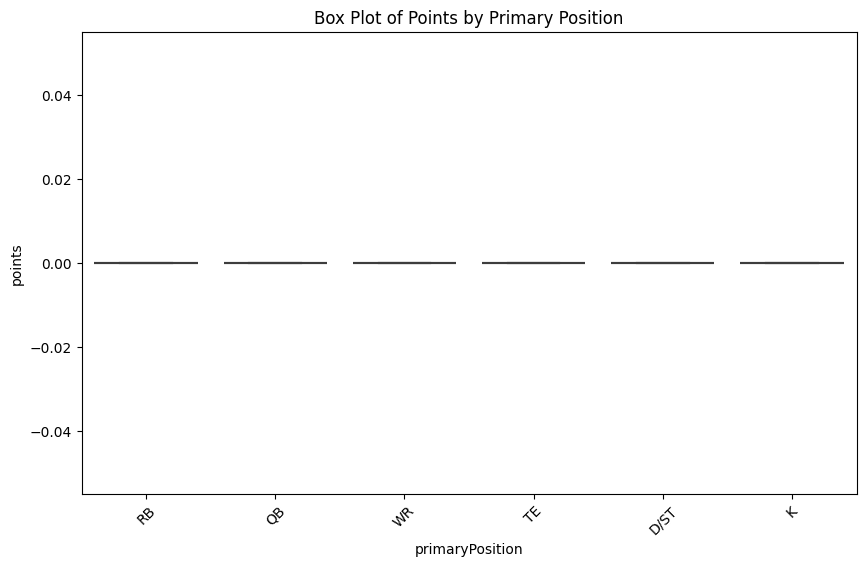

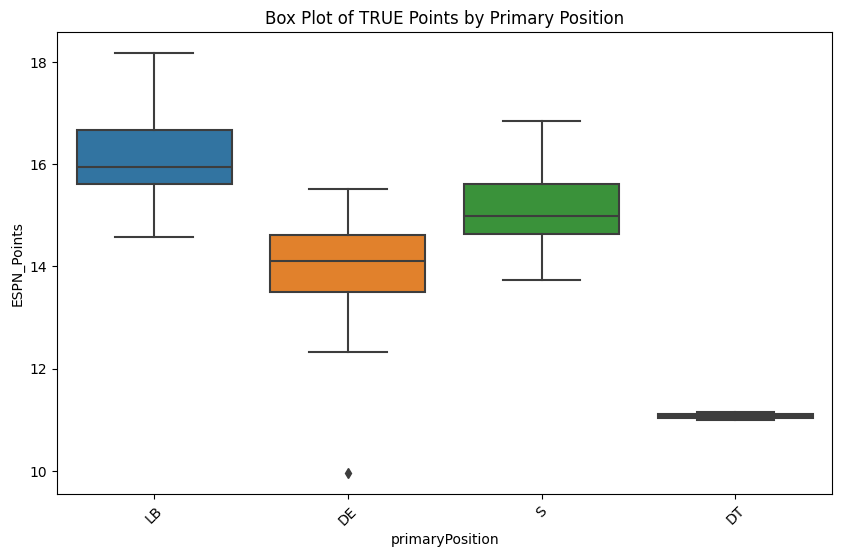

In [62]:
# Box plot for 'points'
plt.figure(figsize=(10, 6))
sns.boxplot(x='primaryPosition', y='points', data=LINEUPS[(LINEUPS['player_active_status'] == 'active') & (~LINEUPS['primaryPosition'].isin(['DE', 'DT', 'CB', 'S', 'LB'])) & (LINEUPS['week'] <= 6)])
plt.title('Box Plot of Points by Primary Position')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Box plot for 'TRUE_Points'
plt.figure(figsize=(10, 6))
sns.boxplot(x='primaryPosition', y='ESPN_Points', data=LINEUPS[(LINEUPS['player_active_status'] == 'active') & (LINEUPS['primaryPosition'].isin(['DE', 'DT', 'CB', 'S', 'LB'])) & (LINEUPS['week'] < 6)])
plt.title('Box Plot of TRUE Points by Primary Position')
plt.xticks(rotation=45)
plt.show()

    primaryPosition      player_name  points  projPoints  TRUE_Points  \
478              LB   Drue Tranquill     0.0       12.19    13.153278   
473              LB    Daiyan Henley     0.0       16.10    16.930337   
435              DE  Nolan Smith Jr.     0.0       10.71    11.090571   
424              DT   Osa Odighizuwa     0.0        7.63     7.940593   
178               S  Kevin Byard III     0.0       14.57    14.570000   
179              CB    Paulson Adebo     0.0       14.92    14.920000   
180              DE     Abdul Carter     0.0        9.96     9.960000   
181              CB     Quentin Lake     0.0       12.36    12.360000   
182              CB    Keisean Nixon     0.0       11.68    11.680000   
183              CB    Renardo Green     0.0       12.25    12.250000   

     projDiff  
478  0.963278  
473  0.830337  
435  0.380571  
424  0.310593  
178  0.000000  
179  0.000000  
180  0.000000  
181  0.000000  
182  0.000000  
183  0.000000  
    primaryPosition 

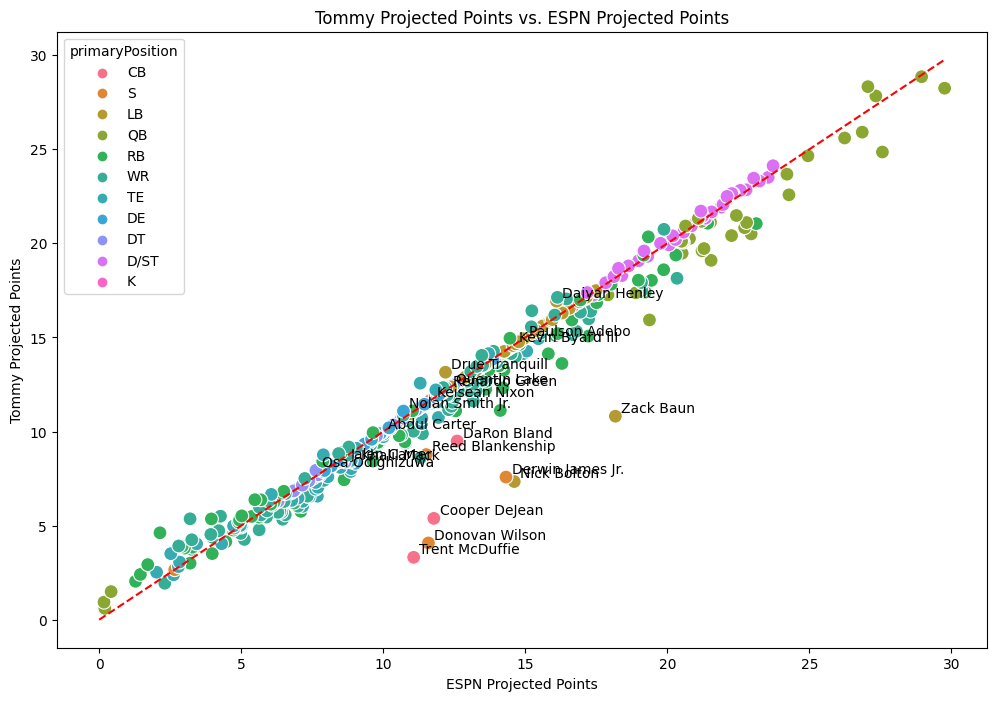

In [48]:
def plot_proj(df, week):

    df['projDiff'] = df['TRUE_Points'] - df['projPoints']

    df = df[(df['projPoints'] > 0) & (df['week'] == week)].groupby(['primaryPosition', 'player_name'])[['points', 'projPoints', 'TRUE_Points', 'projDiff']].mean().sort_values(['projDiff'], ascending=True)
    df = df.reset_index()

    # Get the top 10 highest and 10 lowest values of projDiff
    top_10_projDiff = df[df['primaryPosition'].isin(['CB', 'S', 'LB', 'DE', 'DT'])].nlargest(10, 'projDiff')
    bottom_10_projDiff = df[df['primaryPosition'].isin(['CB', 'S', 'LB', 'DE', 'DT'])].nsmallest(10, 'projDiff')

    # Combine the top and bottom values into one DataFrame
    top_bottom_projDiff = pd.concat([bottom_10_projDiff, top_10_projDiff])

    print(top_10_projDiff)
    print(bottom_10_projDiff)


    plt.figure(figsize=(12, 8))

    scatter_plot = sns.scatterplot(
        y='TRUE_Points', 
        x='projPoints', 
        hue='primaryPosition',  # Color by primaryPosition
        data=df, 
        s=100  # Adjust point size if needed
    )

    # Add labels for each player_name
    for line in range(0, top_bottom_projDiff.shape[0]):
        scatter_plot.text(
            top_bottom_projDiff.projPoints.iloc[line]+0.2,  # Slightly offset the labels on the x-axis
            top_bottom_projDiff.TRUE_Points.iloc[line]+0.2, 
            top_bottom_projDiff.player_name.iloc[line], 
            horizontalalignment='left', 
            size='medium', 
            color='black'
        )

    # Add a line with slope=1 and intercept=0 (line of equality)
    max_val = max(df['TRUE_Points'].max(), df['projPoints'].max())  # Find the maximum value for the plot limit
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')

    # Set plot title and labels
    plt.title('Tommy Projected Points vs. ESPN Projected Points')
    plt.ylabel('Tommy Projected Points')
    plt.xlabel('ESPN Projected Points')

    # Show the plot
    plt.show()

plot_proj(LINEUPS, 1)

### Simulation Sandbox

In [ ]:
sim = django_simulation(league=league, n_simulations=500)

# Convert each list to a DataFrame
df_general = pd.DataFrame(sim[0])
df_position_odds = pd.DataFrame(sim[1])
df_standings = pd.DataFrame(sim[2])

# Merge DataFrames on 'team' and 'owner' columns (assuming they are common keys)
df_merged = df_general.merge(df_position_odds, on=['team', 'owner'], suffixes=('_general', '_odds'))
df_final = df_merged.merge(df_standings, on=['team', 'owner'], suffixes=('', '_standings'))

print(df_final.sort_values(by=['projected_wins'], ascending=[False]))

playoff_odds_swing(league = league, week = 1)

# Power Rankings
print(pd.DataFrame(django_power_rankings(league=league, week=1)))

### Historical Stats

- **Efficiency**
    - The rate at which a team starts an optimal lineup

In [85]:
league_history = scrape_team_stats(league_id=lg_vars[select_league]['ID'],
        start_year=lg_vars[select_league]['start'],
        end_year=lg_vars[select_league]['end'],
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2'])

league_history = league_history[(league_history['year'] <= 2024) | ((league_history['year'] == 2025) & (league_history['week'] <= 0))]

weekly_stats_analysis(df=league_history, year=2024, week=5)
print(" ")
season_stats_analysis(league=league, df=league_history, week=5)
print(" ")
all_time_stats_analysis(league=league, df=league_history)

#h2h_build(df = league_history, owner1 = 'Tommy Winfield', owner2='Corson P')


[BUILDING LEAGUE] Fetching historical stats for 2016...
BUILDING 2016 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2017...
BUILDING 2017 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2018...
BUILDING 2018 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2019...
BUILDING 2019 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2020...
BUILDING 2020 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2021...
BUILDING 2021 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2022...
BUILDING 2022 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2023...
BUILDING 2023 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2024...
BUILDING 2024 Season For Winfield Football 

[BUILDING LEAGUE] Fetching historical stats for 2025...
BUILDING 2025 Season For Winfield 

ZeroDivisionError: float division by zero

In [ ]:
years = range_values = list(range(2024, 2025))
weeks = range_values = list(range(1, 17))
lab = f"{select_league} - Historical Stats From {years[0]} to {years[-1]}"

team_stats_list = []
for y in years:
    league = fetch_league(
        league_id=lg_vars[select_league]['ID'],
        year=y,
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2']
    )
    for week in weeks:
        for i in league.teams:
            # Init DF
            team_stats = {}

            # Teams
            team_lineup = get_lineup(league, i, week=week)
            opp_lineup = get_opp_lineup(league, i, week=week)

            # League Information
            team_stats['leagueName'] = league.name

            # Time
            team_stats['year'] = y
            team_stats['week'] = week

            # Team Information
            team_stats['teamID'] = i.team_id
            team_stats['teamOwner'] = i.owner


            # Efficiency Stats
            team_stats['trueScore'] = np.sum([player.points for player in team_lineup if player.slot_position not in ("BE", "IR")])
            team_stats['bestScore'] = get_best_lineup(league, team_lineup)
            team_stats['efficiencyScore'] = get_lineup_efficiency(league, team_lineup)
            team_stats['projAdherance'] = get_idiot_score(league, team_lineup)
            team_stats['scoreDifference'] = get_score_surprise(league, team_lineup)

            # OppStats
            team_stats['opp_trueScore'] = np.sum([player.points for player in opp_lineup if player.slot_position not in ("BE", "IR")])
            team_stats['opp_bestScore'] = get_best_lineup(league, opp_lineup)
            team_stats['opp_efficiencyScore'] = get_lineup_efficiency(league, opp_lineup)
            team_stats['opp_projAdherance'] = get_idiot_score(league, opp_lineup)
            team_stats['opp_scoreDifference'] = get_score_surprise(league, opp_lineup)

            # Differences
            team_stats['margin'] = team_stats['trueScore'] - team_stats['opp_trueScore']
            team_stats["optimalMargin"] = team_stats['bestScore'] - team_stats['opp_bestScore']
            team_stats["efficiencyMargin"] = team_stats['efficiencyScore'] - team_stats['opp_efficiencyScore']
            team_stats["scoreDifferenceMargin"] = team_stats['scoreDifference'] - team_stats['opp_scoreDifference']

            # Outcomes
            team_stats['isWin'] = np.where(team_stats['margin'] > 0, 1, 0)
            team_stats['isTie'] = np.where(team_stats['margin'] == 0, 1, 0)
            team_stats['isLoss'] = np.where(team_stats['margin'] < 0, 1, 0)
            team_stats['isOptimalWin'] = np.where(team_stats['optimalMargin'] > 0, 1, 0)
            team_stats['isOptimalTie'] = np.where(team_stats['optimalMargin'] == 0, 1, 0)
            team_stats['isOptimalLoss'] = np.where(team_stats['optimalMargin'] < 0, 1, 0)
            team_stats['netWinsAdded'] = np.where((team_stats['isWin'] == 1) & (team_stats['isOptimalWin'] == 0), 1, 0)
            team_stats['netLossAdded'] = np.where((team_stats['isLoss'] == 1) & (team_stats['isOptimalWin'] == 1), 1, 0)
            team_stats['netLuck'] = team_stats['netWinsAdded'] - team_stats['netLossAdded']

            # Luck
            try:
                team_stats['luckIndex'] = get_weekly_luck_index(league=league, team = i, week=week)
            except:
                team_stats['luckIndex'] = 0

            # Append
            if y < 2024 or (y == 2024 and week < 3):
                team_stats_list.append(team_stats)
                
team_stats_df = pd.DataFrame(team_stats_list)


In [ ]:
# Group By # , 'year'
hist_stats_df = team_stats_df.groupby(['leagueName', 'week', 'teamID', 'teamOwner']).agg(
    Efficency = ('efficiencyScore', 'mean'),
    W=("isWin", "sum"),
    L=("isLoss", "sum"),
    T=("isTie", "sum"),
    xW=("isOptimalWin", "sum"),
    xL=("isOptimalLoss", "sum"),
    xT=("isOptimalTie", "sum"),
    Luck_W=("netLuck", "sum"),
    TruePF=('trueScore', 'mean'),
    OptimalPF=('bestScore', 'mean'),
    TruePA=('opp_trueScore', 'mean'),
    OptimalPA=('opp_bestScore', 'mean'),
    AdhereProj = ('projAdherance', 'mean'),
    TrueMargin = ('margin', 'mean'),
    #OptimalMargin = ('optimalMargin', 'mean'),
    #PF_OnTable = ('scoreDifference', 'mean'),
    Luck_Index = ('luckIndex', 'mean')
    ).reset_index()\
     .sort_values(by=['Luck_Index'], ascending=False)

print(lab)
hist_stats_df

In [ ]:
# Mapping
years = hist_stats_df['year'].sort_values(ascending=False).unique()
cmap = plt.get_cmap('tab10')
color_dict = {year: cmap(i) for i, year in enumerate(years)}

# Plotting
plt.figure(figsize=(12, 8))

plt.scatter(
    hist_stats_df['AdhereProj'],
    hist_stats_df['Efficency'],
    c=hist_stats_df['year'].map(color_dict),
    label='Data Points')

# Adding labels
texts = []
for i in range(len(hist_stats_df)):
    owner_year = f"{hist_stats_df['teamOwner'][i]}"
    texts.append(plt.text(hist_stats_df['AdhereProj'][i], hist_stats_df['Efficency'][i],
                          owner_year, fontsize=9, ha='center'))
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red', lw=0.5))

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[year], markersize=10) 
           for year in years]
plt.legend(handles, years, title="Year")
    

plt.xlabel('Adherance To ESPN Projections')
plt.ylabel('Correct Start Rate')
plt.title('Scatter Plot of Adherance To Projections vs. Correct Start Rate')
plt.grid(True)
plt.show()

## Projections

In [ ]:
years = range_values = list(range(2024, 2025))
stats_df = pd.DataFrame()
for y in years:
        ply_stats = get_stats_by_matchup(league_id=lg_vars[select_league]['ID'],
                year=y,
                swid=lg_vars[select_league]['SWID'],
                espn_s2=lg_vars[select_league]['ESPN_S2'])
        
        stats_df = pd.concat([stats_df, ply_stats]).fillna(0)


stats_df.head()

In [ ]:
stats_df['diff'] = stats_df['points'] - stats_df['projPoints']
# Set up plot area
plt.figure(figsize=(12, 8))

# Create a violin plot for each primaryPosition
sns.violinplot(x='slotPosition', y='points', data=stats_df)

# Labels and title
plt.xlabel('Primary Position')
plt.ylabel('Points')
plt.title('Distribution of Points by Primary Position')

# Show plot
plt.show()

In [ ]:
stats_df = stats_df[stats_df['week'] < 3]
grouped_df = stats_df[stats_df['week'] < 3].groupby(['year','week', 'primaryPosition', 'player_name'])

positions = stats_df['primaryPosition'].unique()

# Set up plot area
plt.figure(figsize=(20, 12))

# Loop through each primaryPosition
for pos in positions:
    pos_data = stats_df[stats_df['primaryPosition'] == pos]
    
    # Scatter plot
    plt.scatter(pos_data['points'], pos_data['projPoints'], label=pos)

    # Calculate R² using Linear Regression
    X = pos_data['points'].values.reshape(-1, 1)
    y = pos_data['projPoints'].values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))

    # Display R² value
    plt.text(pos_data['points'].mean(), pos_data['projPoints'].mean(), f"R²: {r2:.2f}", fontsize=9)

# Labels and legend
plt.xlabel('Points')
plt.ylabel('Projected Points')
plt.title('Points vs Projected Points by Primary Position')
plt.legend(title="Primary Position")
plt.show()

In [ ]:
# Get unique positions
positions = stats_df['player_name'].unique()

# Set up multi-plot grid
n_cols = 3
n_rows = (len(positions) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each player_name and create scatter plots
for i, pos in enumerate(positions):
    pos_data = stats_df[stats_df['player_name'] == pos]
    
    # Scatter plot
    sns.scatterplot(x='points', y='projPoints', data=pos_data, ax=axes[i], color='blue')
    
    # Calculate R² using Linear Regression
    X = pos_data['points'].values.reshape(-1, 1)
    y = pos_data['projPoints'].values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))
    
    # Add R² value to the plot
    axes[i].text(0.05, 0.95, f'R²: {r2:.2f}', transform=axes[i].transAxes, fontsize=12, verticalalignment='top')
    
    # Set title and labels
    axes[i].set_title(f"Primary Position: {pos}")
    axes[i].set_xlabel('Points')
    axes[i].set_ylabel('Projected Points')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Positional Variance Between Projections and Actual

### Power Rankings

In [ ]:
league.power_rankings(league.current_week)

In [ ]:
get_season_luck_indices(league, week)